In [ ]:
!git clone https://github.com/MartinGer/Stand-Alone-Self-Attention-in-Vision-Models

Cloning into 'Stand-Alone-Self-Attention-in-Vision-Models'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 22 (delta 4), reused 13 (delta 3), pack-reused 0
Unpacking objects: 100% (22/22), done.


In [ ]:
import os, sys, pathlib
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random, time
random.seed(10)

In [ ]:
# os.chdir('/root/.fastai/data/imagenette2-320/val/')
# os.getcwd()

In [ ]:
%ls

sample_data/  Stand-Alone-Self-Attention-in-Vision-Models/


In [ ]:
training = True

num_heads = 16
filename = 'export_'+str(num_heads)+'heads_noattention.pkl'
print("filename: ", filename)

drive_model_path = r'/content/gdrive/My Drive/'

filename:  export_16heads_noattention.pkl


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
t0 = time.time()

In [ ]:
# %ls
os.chdir('Stand-Alone-Self-Attention-in-Vision-Models/')

In [ ]:
os.getcwd()

'/content/Stand-Alone-Self-Attention-in-Vision-Models'

In [ ]:
from fastai.vision.all import *
from SASA_Model import resnet50

In [ ]:
CLASSES = 10

def prepare_data(img_size, batch_size):
    path = untar_data(URLs.IMAGENETTE_320)
    item_tfms=RandomResizedCrop(size=img_size, min_scale=0.8)
    batch_tfms=[*aug_transforms(flip_vert=False, max_lighting=0.2, max_rotate=15., max_zoom=1.1, max_warp=0.2, p_affine=0.75, p_lighting=0.75), 
                Normalize.from_stats(*imagenet_stats)]
    dls = ImageDataLoaders.from_folder(path, valid='val', item_tfms=item_tfms, batch_tfms=batch_tfms, bs=batch_size)  
    return dls

ds = prepare_data(224, 20)

In [ ]:
class_names = ["tench", "English springer", "cassette player", 
               "chain saw", "church", "French horn", 
               "garbage truck", "gas pump", "golf ball", 
               "parachute"]

class_code_names = {"n01440764": ["tench", 0],
                    "n02102040": ["English springer", 1],
                    "n02979186": ["cassette player", 2],
                    "n03000684": ["chain saw", 3],
                    "n03028079": ["church", 4],
                    "n03394916": ["French horn", 5],
                    "n03417042": ["garbage truck", 6],
                    "n03425413": ["gas pump", 7],
                    "n03445777": ["golf ball",  8],
                    "n03888257": ["parachute", 9]}

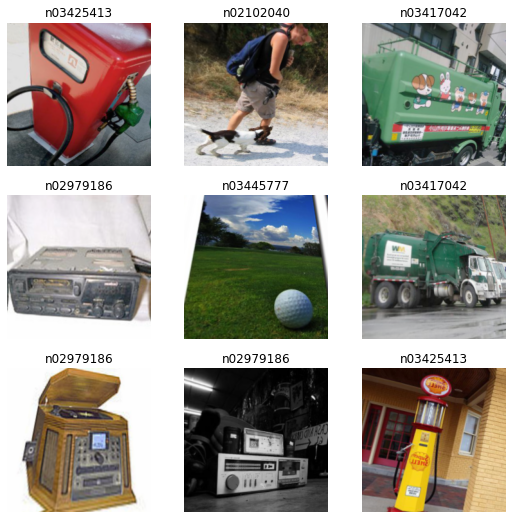

In [ ]:
ds.show_batch()

In [ ]:


model = resnet50(num_classes=CLASSES, attention=[False,False,False,False], num_heads=num_heads)
# model = resnet50(num_classes=CLASSES, attention=[False,False,True,True], num_heads=num_heads)
# model = resnet50(num_classes=CLASSES, attention=[True,True,True,True], num_heads=num_heads)

learn = Learner(ds, model, opt_func=Adam, metrics=accuracy)

In [ ]:
epochs = 50
lr = 1e-3 # estaba en 1e-4
if training == True:
#   cbs=[ReduceLROnPlateau(monitor='accuracy', min_delta=0.001, patience=10, factor=3, min_lr=1e-8), SaveModelCallback(),
#        EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=5)]
  cbs=[ReduceLROnPlateau(monitor='accuracy', min_delta=0.001, patience=10, factor=3, min_lr=1e-8), SaveModelCallback()]

  learn.fit(n_epoch=epochs, lr=lr, 
            cbs = cbs) 
  print("Training time: ", time.time() - t0)

epoch,train_loss,valid_loss,accuracy,time
0,1.942435,2.314354,0.259618,02:12
1,1.620121,1.598657,0.478726,02:11
2,1.489557,1.363785,0.550828,02:09
3,1.224992,1.285859,0.590064,02:10
4,1.105121,1.003840,0.680510,02:09
5,1.066813,0.983619,0.683312,02:09
6,1.017928,0.944549,0.700127,02:09
7,0.956295,0.939182,0.695541,02:09
8,0.926733,0.842621,0.733758,02:09
9,0.806862,0.893523,0.717452,02:09


Better model found at epoch 0 with valid_loss value: 2.314354419708252.
Better model found at epoch 1 with valid_loss value: 1.5986567735671997.
Better model found at epoch 2 with valid_loss value: 1.3637847900390625.
Better model found at epoch 3 with valid_loss value: 1.2858593463897705.
Better model found at epoch 4 with valid_loss value: 1.0038398504257202.
Better model found at epoch 5 with valid_loss value: 0.9836187362670898.
Better model found at epoch 6 with valid_loss value: 0.944549024105072.
Better model found at epoch 7 with valid_loss value: 0.9391818046569824.
Better model found at epoch 8 with valid_loss value: 0.8426209092140198.
Better model found at epoch 11 with valid_loss value: 0.7282296419143677.
Better model found at epoch 14 with valid_loss value: 0.7169850468635559.


In [ ]:
learn.path

In [ ]:
if training == True:
  learn.path = pathlib.Path('/content/Stand-Alone-Self-Attention-in-Vision-Models')

In [ ]:
if training == True:
  learn.export()

In [ ]:
import shutil

if training == True:
  os.rename(str(learn.path / 'export.pkl'), str(learn.path / filename))
  shutil.copyfile(str(learn.path / filename), drive_model_path + filename)

In [ ]:
learn = load_learner(drive_model_path + filename)

In [ ]:
test_files = [fn for fn in sorted(pathlib.Path('/root/.fastai/data/imagenette2-320/val').glob('**/*')) if fn.is_file()]
random.shuffle(test_files)

In [ ]:
len(test_files)

In [ ]:
test_dl = learn.dls.test_dl(test_files[:100])

In [ ]:
# test_dl.items

In [ ]:
preds, _ = learn.get_preds(dl=test_dl)


In [ ]:
preds = preds.cpu().detach().numpy()
preds = preds.argmax(axis=-1)

In [ ]:
preds.shape

In [ ]:
preds

In [ ]:
def getReference(dl, class_code_names):
  class_names = []
  class_values = []
  for item in dl.items:
    class_code_name = str(item).split("/")[-2]
    class_names.append(class_code_names[class_code_name][0])
    class_values.append(class_code_names[class_code_name][1])
    

  return class_names, class_values
    
reference_names_test, reference_test = getReference(test_dl, class_code_names)
print(reference_names_test, reference_test)

In [ ]:
import sklearn.metrics as metrics 

acc = round(metrics.accuracy_score(reference_test, preds), 2)
print("Accuracy: ", acc)




In [ ]:
class_names = ["tench", "English springer", "cassette player", 
               "chain saw", "church", "French horn", 
               "garbage truck", "gas pump", "golf ball", 
               "parachute"]

In [ ]:
inference_idx = 15
im = cv2.imread(str(test_files[inference_idx]))
im.shape
plt.imshow(im)
plt.title("Predicted: " + class_names[preds[inference_idx]] + ". GT: " + reference_names_test[inference_idx])

In [ ]:
print("Execution time: ", time.time() - t0)